Montando Google Drive...
Mounted at /content/drive
✅ Google Drive montado com sucesso.
Tentando carregar histórico de métricas de: /content/drive/MyDrive/Mestrado/Curso/1o Semestre 2025/DeepLearning/UrbanSound8K_dataset/modelos_finetune_US8K/kfold_metrics_history.pkl
✅ Histórico de métricas carregado com sucesso para plotagem.
Nomes das classes detectados: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

Gerando: Gráfico de Linha da Acurácia e Loss de Validação por Fold...


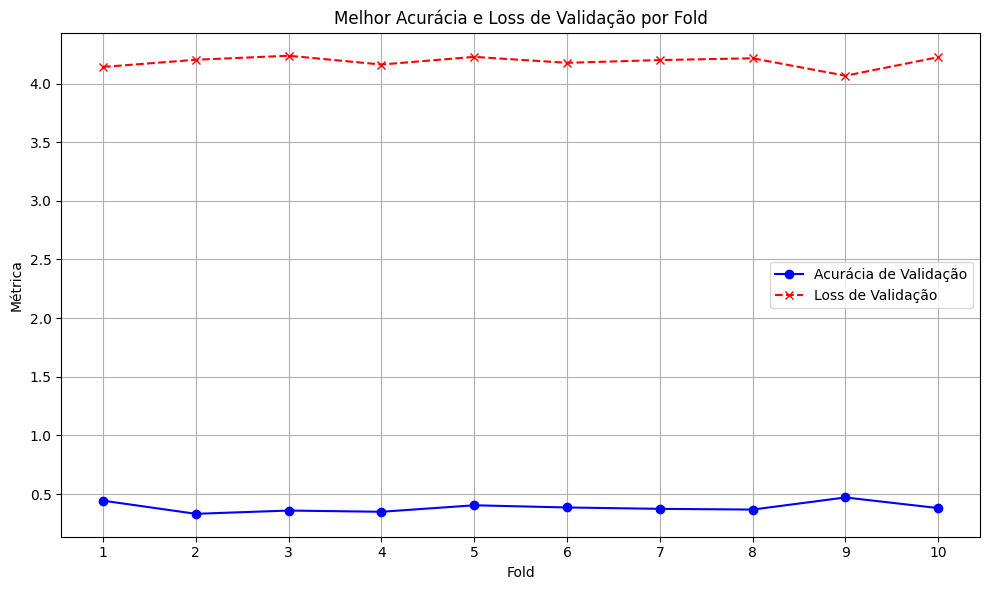

Gerando: Gráfico de Barras da Acurácia por Classe (Média e Desvio Padrão)...


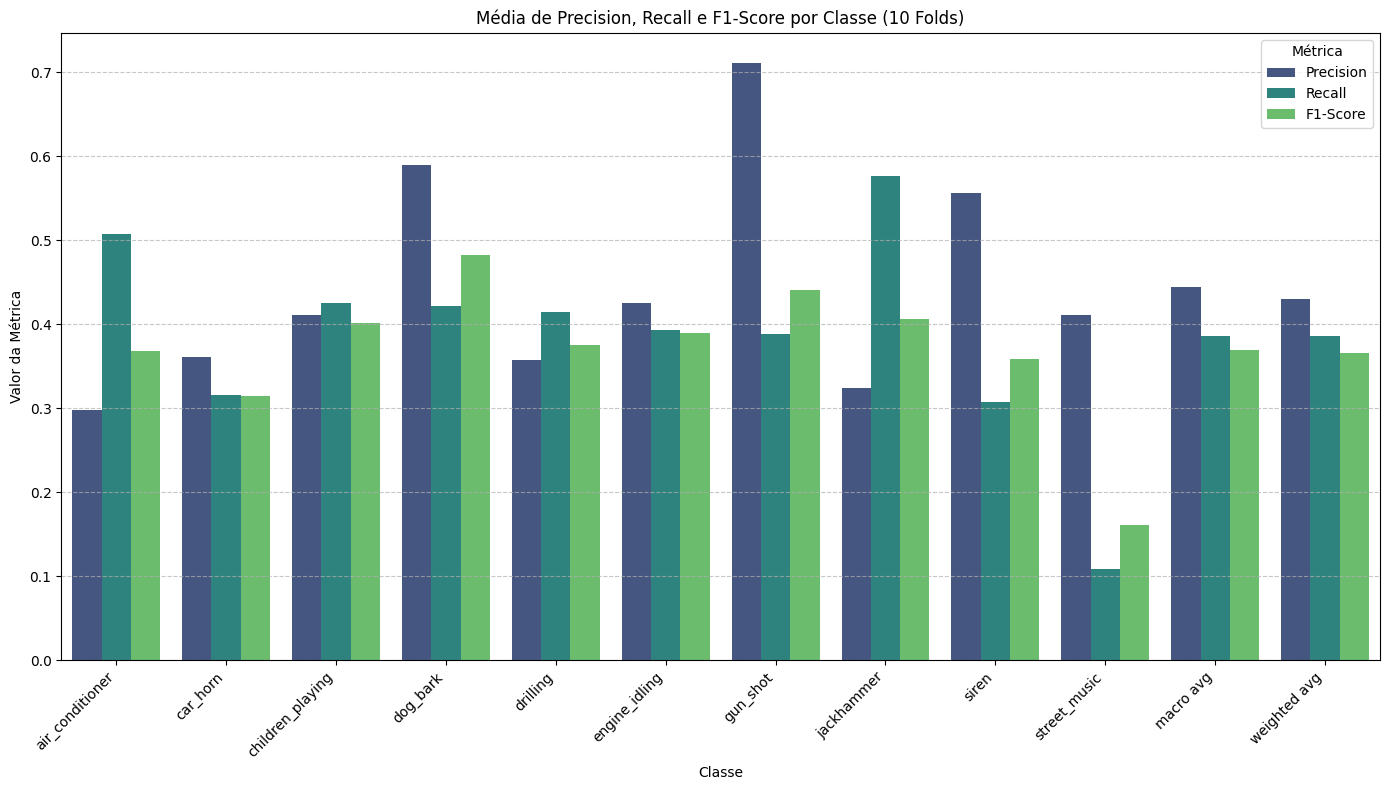

Gerando: Heatmap da Matriz de Confusão Média...


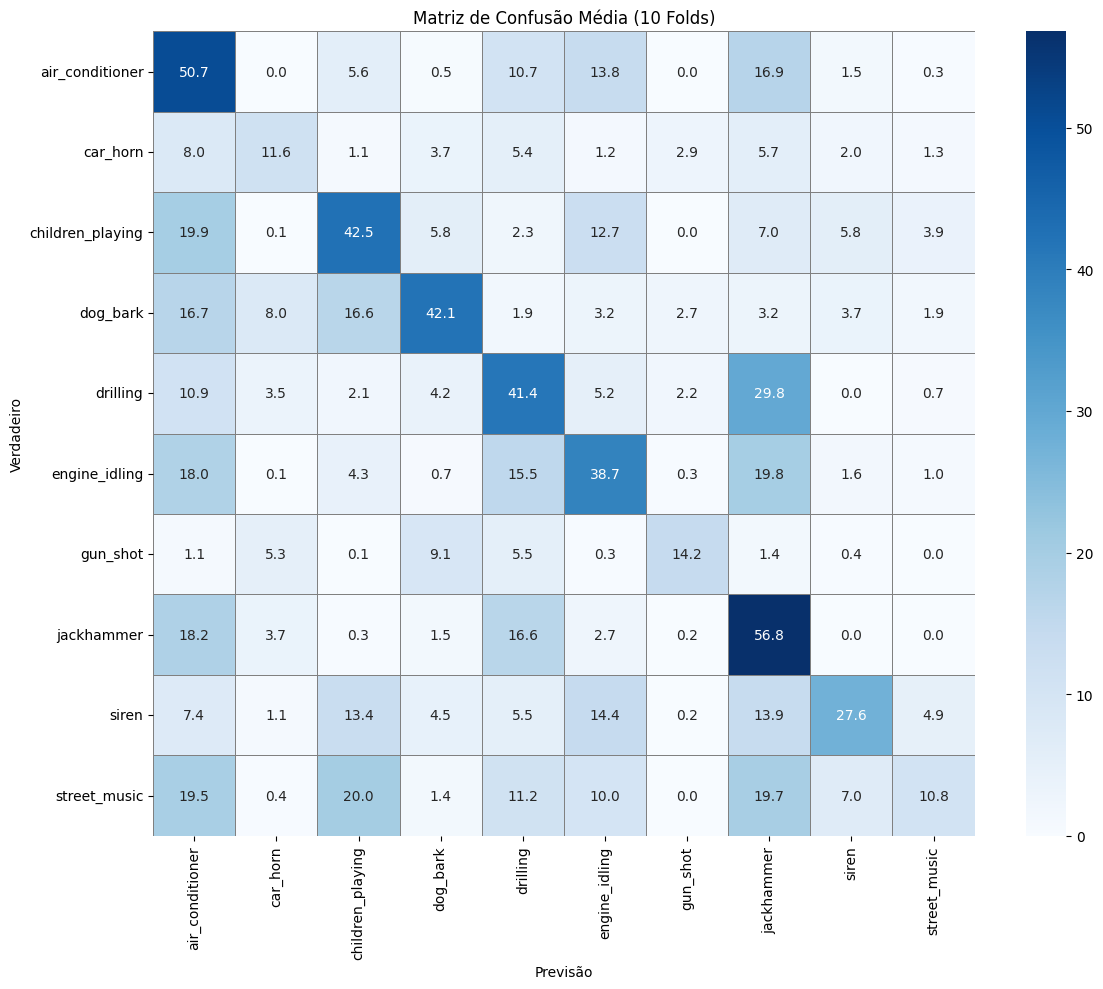

Gerando: Box Plot das Épocas até o Early Stopping por Fold...


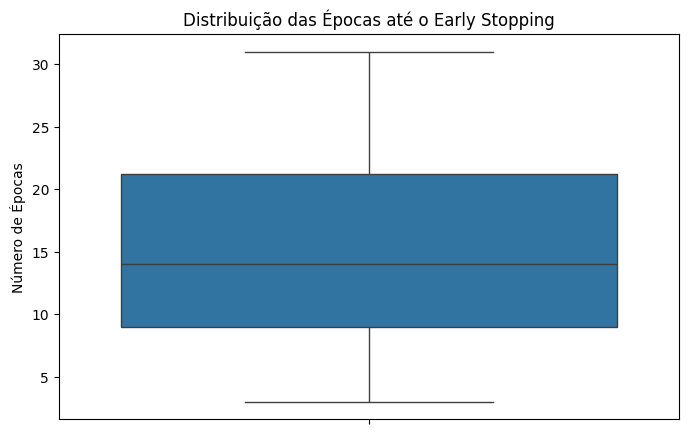

Gerando: Gráfico de Barras do Tempo de Execução por Fold...


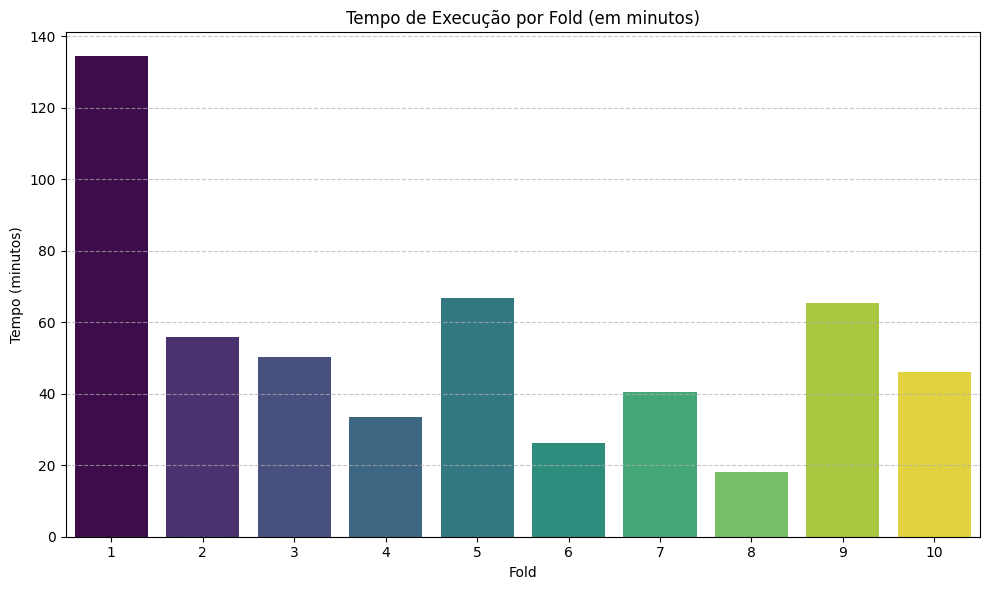


Todos os gráficos foram gerados (se os dados estavam disponíveis).


In [ ]:
"""
Script para carregar e plotar os resultados do experimento K-Fold
a partir do arquivo kfold_metrics_history.pkl.
"""

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive # Importar para montar o Drive
import os # Importar para gerenciar caminhos

# BLOCO 1: Montar Google Drive e Definir Caminhos
# --------------------------------------------------------------------------------
print("Montando Google Drive...")
try:
    drive.mount('/content/drive')
    print("✅ Google Drive montado com sucesso.")
except Exception as e:
    print(f"❌ ERRO ao montar o Google Drive: {e}")
    print("Por favor, verifique sua conexão ou permissões.")
    exit()

# Caminho base para o dataset UrbanSound8K e modelos
base_path_us8k = "/content/drive/MyDrive/Mestrado/Curso/1o Semestre 2025/DeepLearning/UrbanSound8K_dataset"
model_save_path_us8k = os.path.join(base_path_us8k, "modelos_finetune_US8K")

# Caminho para o arquivo de histórico de métricas
metrics_history_file = os.path.join(model_save_path_us8k, "kfold_metrics_history.pkl")

print(f"Tentando carregar histórico de métricas de: {metrics_history_file}")

# Carregar os dados
try:
    with open(metrics_history_file, 'rb') as f:
        loaded_data = pickle.load(f)
        all_fold_metrics = loaded_data.get('all_fold_metrics', [])
        all_fold_classification_reports = loaded_data.get('all_fold_classification_reports', [])
        all_fold_confusion_matrices = loaded_data.get('all_fold_confusion_matrices', [])
        # all_fold_times = loaded_data.get('all_fold_times', []) # Já incluído em all_fold_metrics

    print("✅ Histórico de métricas carregado com sucesso para plotagem.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo de histórico não encontrado em {metrics_history_file}")
    print("Certifique-se de que o experimento K-Fold foi executado e o arquivo 'kfold_metrics_history.pkl' foi salvo no caminho especificado.")
    exit()
except Exception as e:
    print(f"❌ Erro ao carregar o arquivo de histórico: {e}")
    print("O arquivo pode estar corrompido ou ter sido salvo em um formato incompatível.")
    exit()

# Verificar se há dados para plotar
if not all_fold_metrics:
    print("Nenhum dado de métricas de folds foi carregado. Não há gráficos para gerar.")
    exit()

# Extrair os nomes das classes (assumindo que são consistentes em todos os reports)
# Tenta obter do primeiro relatório de classificação disponível.
if all_fold_classification_reports:
    # Filtra as chaves que não são métricas globais para obter os nomes das classes
    class_names_us8k = sorted([k for k in all_fold_classification_reports[0].keys() if k not in ['accuracy', 'macro avg', 'weighted avg']])
else:
    print("Nenhum relatório de classificação disponível para extrair nomes de classes.")
    # Fallback ou você pode definir manualmente se souber
    class_names_us8k = [
        'air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
        'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music'
    ]
print(f"Nomes das classes detectados: {class_names_us8k}")


# --- 1. Gráfico de Linha da Acurácia e Loss de Validação por Fold ---
print("\nGerando: Gráfico de Linha da Acurácia e Loss de Validação por Fold...")
folds = [m['fold'] for m in all_fold_metrics]
accuracies = [m['best_accuracy'] for m in all_fold_metrics]
losses = [m['best_loss'] for m in all_fold_metrics]

plt.figure(figsize=(10, 6))
plt.plot(folds, accuracies, marker='o', linestyle='-', color='blue', label='Acurácia de Validação')
plt.plot(folds, losses, marker='x', linestyle='--', color='red', label='Loss de Validação')
plt.title('Melhor Acurácia e Loss de Validação por Fold')
plt.xlabel('Fold')
plt.ylabel('Métrica')
plt.xticks(folds)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. Gráfico de Barras da Acurácia por Classe (Média e Desvio Padrão) ---
print("Gerando: Gráfico de Barras da Acurácia por Classe (Média e Desvio Padrão)...")
aggregated_report_data = {}
# Inclui as classes específicas e as médias macro/weighted
for class_name in class_names_us8k + ['macro avg', 'weighted avg']:
    aggregated_report_data[class_name] = {'precision': [], 'recall': [], 'f1-score': []}

for report in all_fold_classification_reports:
    for class_name in class_names_us8k + ['macro avg', 'weighted avg']:
        if class_name in report:
            # report['accuracy'] é uma chave separada, não tem precision/recall/f1
            if class_name == 'accuracy': # Caso queira plotar acurácia geral aqui tbm
                # F1-score é uma placeholder para a acurácia global
                aggregated_report_data[class_name]['f1-score'].append(report['accuracy'])
            else:
                if 'precision' in report[class_name]: # Garante que as chaves existem
                    aggregated_report_data[class_name]['precision'].append(report[class_name]['precision'])
                    aggregated_report_data[class_name]['recall'].append(report[class_name]['recall'])
                    aggregated_report_data[class_name]['f1-score'].append(report[class_name]['f1-score'])


# Preparar dados para o DataFrame do seaborn
plot_data = []
for class_name, metrics in aggregated_report_data.items():
    if metrics['precision']: # Garante que há dados para precision, recall, f1-score
        plot_data.append({
            'Classe': class_name,
            'Métrica': 'Precision',
            'Média': np.mean(metrics['precision']),
            'Std': np.std(metrics['precision'])
        })
        plot_data.append({
            'Classe': class_name,
            'Métrica': 'Recall',
            'Média': np.mean(metrics['recall']),
            'Std': np.std(metrics['recall'])
        })
        plot_data.append({
            'Classe': class_name,
            'Métrica': 'F1-Score',
            'Média': np.mean(metrics['f1-score']),
            'Std': np.std(metrics['f1-score'])
        })
    elif class_name == 'accuracy' and metrics['f1-score']: # Caso especial para acurácia global
        plot_data.append({
            'Classe': 'Global Accuracy', # Renomeia para clareza no plot
            'Métrica': 'Accuracy',
            'Média': np.mean(metrics['f1-score']),
            'Std': np.std(metrics['f1-score'])
        })


df_plot = pd.DataFrame(plot_data)

plt.figure(figsize=(14, 8))
sns.barplot(x='Classe', y='Média', hue='Métrica', data=df_plot, palette='viridis', errorbar='sd') # 'sd' para desvio padrão
plt.title('Média de Precision, Recall e F1-Score por Classe (10 Folds)')
plt.xlabel('Classe')
plt.ylabel('Valor da Métrica')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 3. Heatmap da Matriz de Confusão Média ---
print("Gerando: Heatmap da Matriz de Confusão Média...")
if all_fold_confusion_matrices:
    # Garante que todas as matrizes tenham o mesmo shape antes de calcular a média
    if all_fold_confusion_matrices:
        ref_shape = all_fold_confusion_matrices[0].shape
        valid_matrices = [cm for cm in all_fold_confusion_matrices if cm.shape == ref_shape]

        if valid_matrices:
            mean_cm = np.mean(valid_matrices, axis=0) # Manter float para o heatmap
            plt.figure(figsize=(12, 10)) # Aumentar o tamanho para melhor visualização
            sns.heatmap(mean_cm, annot=True, fmt='.1f', cmap='Blues',
                        xticklabels=class_names_us8k, yticklabels=class_names_us8k,
                        linewidths=.5, linecolor='gray') # Adiciona linhas para melhor separação
            plt.xlabel('Previsão')
            plt.ylabel('Verdadeiro')
            plt.title('Matriz de Confusão Média (10 Folds)')
            plt.tight_layout()
            plt.show()
        else:
            print("Não foi possível gerar a matriz de confusão média (matrizes com shapes inconsistentes ou vazias).")
    else:
        print("Nenhuma matriz de confusão coletada para gerar o heatmap.")

# --- 4. Box Plot das Épocas até o Early Stopping por Fold ---
print("Gerando: Box Plot das Épocas até o Early Stopping por Fold...")
epochs_reached = [m['best_epoch'] for m in all_fold_metrics]
if epochs_reached:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=epochs_reached)
    plt.title('Distribuição das Épocas até o Early Stopping')
    plt.ylabel('Número de Épocas')
    plt.show()
else:
    print("Nenhum dado de 'epochs_reached' para gerar o Box Plot.")


# --- 5. Gráfico de Barras do Tempo de Execução por Fold ---
print("Gerando: Gráfico de Barras do Tempo de Execução por Fold...")
fold_times = [m['time_seconds'] / 60 for m in all_fold_metrics] # Em minutos
if fold_times:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=folds, y=fold_times, palette='viridis', hue=folds, legend=False)
    plt.title('Tempo de Execução por Fold (em minutos)')
    plt.xlabel('Fold')
    plt.ylabel('Tempo (minutos)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum dado de 'fold_times' para gerar o gráfico de barras.")

print("\nTodos os gráficos foram gerados (se os dados estavam disponíveis).")